# Trialling Demand Profiles for stations

There are various approaches to this:
* Rebalanced Effective Usage - Chardon et al. This is the cumulative net arrivals minus departures over a typical weekday. 
* Fluid Model - O'Mahoney etc. which is similar to REU but involves censoring observations where arrivals or departures were impossible due to full or empty (respectively) stations. 
* Markov Chain Model - O'Mahoney etc. 

In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
import sqlite3
import os

In [3]:
# work from the project root
if os.getcwd().endswith('notebooks'):
    os.chdir("..")

In [4]:
dbpath = Path('tfl_project/data/bike_db.db')
db = sqlite3.connect(dbpath)

# 1 Relbalanced Effective Usage (REU)

In [42]:
group_mins = 10 

df1 = pd.read_sql_query(f"""
    WITH 
        departures AS (
            SELECT
                "StartStation Id" AS station
                ,CAST(minute_of_day/{group_mins} AS INT)*{group_mins} AS time_period
                ,COUNT(*) AS departures
            FROM
                journeys
            WHERE
                year = 2019
                AND weekday_ind = 1
                AND "StartStation Id" > 0
            GROUP BY
                1,2)
        ,arrivals AS (
            SELECT
                "EndStation Id" AS station
                ,CAST((strftime('%H',"End Date")*60 + strftime('%M',"End Date"))/{group_mins} AS INT)*{group_mins} AS time_period
                ,COUNT(*) AS arrivals
            FROM
                journeys
            WHERE
                -- For indexing-purposes I assume that Start Date and End Date have the same year
                -- and the same weekday_ind. This will be false for a trace number of fringe cases, but does
                -- not justify creating new indexes and columns. 
                year = 2019
                AND weekday_ind = 1
                AND "EndStation Id" > 0
            GROUP BY
                1,2)

        ,joiner AS (
            SELECT station, time_period FROM departures
            UNION
            SELECT station, time_period FROM arrivals
        )

    SELECT
        joiner.station
        ,joiner.time_period
        ,IFNULL(departures,0) AS departures
        ,IFNULL(arrivals, 0) AS arrivals
    FROM 
        -- SQLite does not support outer joins, so this is a workaround. 
        joiner
        LEFT JOIN departures
            ON joiner.station = departures.station
            AND joiner.time_period = departures.time_period
        LEFT JOIN arrivals
            ON joiner.station = arrivals.station
            AND joiner.time_period = arrivals.time_period
    ;"""
,db)

In [43]:
df1['avg_departures'] = df1['departures']/365
df1['avg_arrivals'] = df1['arrivals']/365
df1['net_arrivals'] = df1['arrivals'] - df1['departures']
df1['avg_net_arrivals'] = df1['net_arrivals'] / 365

One-minute aggregate:

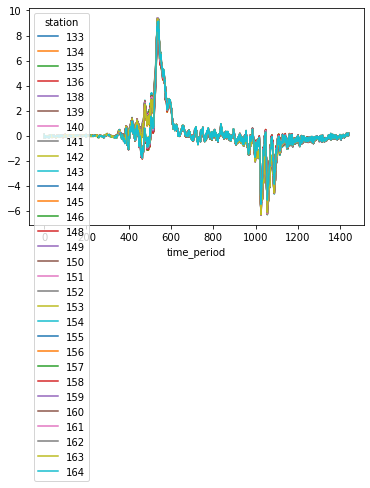

In [41]:
df1.pivot_table(index='time_period', columns='station', values='avg_net_arrivals').cumsum(axis=1).iloc[:,130:160].plot()

10 minute aggregate

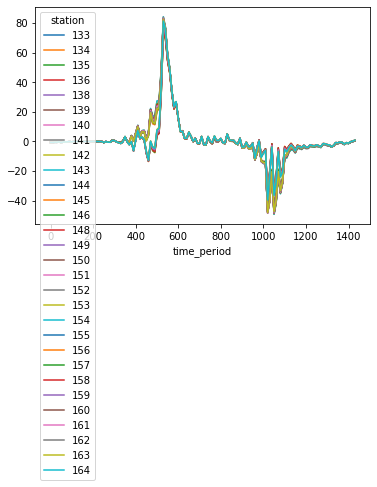

In [44]:
df1.pivot_table(index='time_period', columns='station', values='avg_net_arrivals').cumsum(axis=1).iloc[:,130:160].plot()

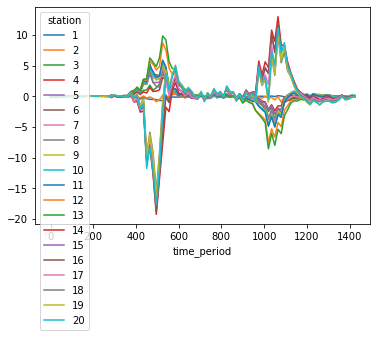

In [32]:
df1.pivot_table(index='time_period', columns='station', values='avg_net_arrivals').cumsum(axis=1).iloc[:,:20].plot()

Todo: The amplitude depends on the aggregation of time. 
Check you understand how the other authors did this. 
Consider not aggregating and just doing this by minute. 

In [5]:
df2 = pd.read_sql_query(f"""
    WITH 
        departures AS (
            SELECT
                "StartStation Id" AS station
                ,strftime('%j', "Start Date") AS day_of_year
                ,CAST(minute_of_day/10 AS INT)*10 AS time_period
                ,COUNT(*) AS departures
            FROM
                journeys
            WHERE
                year = 2019
                AND weekday_ind = 1
                AND "StartStation Id" > 0
            GROUP BY
                1,2,3)
        ,arrivals AS (
            SELECT
                "EndStation Id" AS station
                ,strftime('%j', "End Date") AS day_of_year
                ,CAST((strftime('%H',"End Date")*60 + strftime('%M',"End Date"))/10 AS INT)*10 AS time_period
                ,COUNT(*) AS arrivals
            FROM
                journeys
            WHERE
                -- For indexing-purposes I assume that Start Date and End Date have the same year
                -- and the same weekday_ind. This will be false for a trace number of fringe cases, but does
                -- not justify creating new indexes and columns. 
                year = 2019
                AND weekday_ind = 1
                AND "EndStation Id" > 0
            GROUP BY
                1,2,3)

        ,joiner AS (
            SELECT station, time_period, day_of_year FROM departures
            UNION
            SELECT station, time_period, day_of_year FROM arrivals
        )

    SELECT
        joiner.station
        ,joiner.day_of_year
        ,joiner.time_period
        ,IFNULL(departures,0) AS departures
        ,IFNULL(arrivals, 0) AS arrivals
    FROM 
        -- SQLite does not support outer joins, so this is a workaround. 
        joiner
        LEFT JOIN departures
            ON joiner.station = departures.station
            AND joiner.time_period = departures.time_period
            AND joiner.day_of_year = departures.day_of_year
        LEFT JOIN arrivals
            ON joiner.station = arrivals.station
            AND joiner.time_period = arrivals.time_period
            AND joiner.day_of_year = arrivals.day_of_year
    ;"""
,db)

In [6]:
df2.head()

,station,day_of_year,time_period,departures,arrivals
0,1,010,0,1,0
1,1,066,0,0,1
2,1,073,0,0,1
3,1,103,0,0,1
4,1,135,0,1,0


In [13]:
piv2 = df2.pivot_table(index=['station','day_of_year'], columns=['time_period'], values=['arrivals','departures'], fill_value=0)

In [14]:
piv2.head()

arrivals                                               \
time_period             0    10   20   30   40   50   60   70   80   90     
station day_of_year                                                         
1       001                0    0    0    0    0    0    0    0    1    0   
        002                0    0    0    0    0    0    0    0    0    0   
        003                0    0    0    0    0    0    0    0    0    0   
        004                0    0    0    0    0    0    0    0    0    0   
        007                0    0    0    0    0    0    0    0    0    0   

                     ... departures                                          \
time_period          ...       1340 1350 1360 1370 1380 1390 1400 1410 1420   
station day_of_year  ...                                                      
1       001          ...          0    0    0    0    0    0    0    0    0   
        002          ...          0    0    0    0    0    0    0    0    0   
        003          ...          0    0    1    0    0    0    0    0    0   
        004          ...          0    0    0    0    0    0    0    0    0   
        007          ...          0    0    0    0    0    0    0    0    0   

                          
time_period         1430  
station day_of_year       
1       001            0  
        002            0  
        003            0  
        004            0  
        007            0  

[5 rows x 288 columns]

In [21]:
piv2 = piv2.stack(level=0)

In [22]:
piv2.head()

time_period                     0     10    20    30    40    50    60    \
station day_of_year                                                        
1       001         arrivals       0     0     0     0     0     0     0   
                    departures     0     0     0     0     0     0     0   
        002         arrivals       0     0     0     0     0     0     0   
                    departures     0     0     0     0     0     0     0   
        003         arrivals       0     0     0     0     0     0     0   

time_period                     70    80    90    ...  1340  1350  1360  1370  \
station day_of_year                               ...                           
1       001         arrivals       0     1     0  ...     0     0     0     0   
                    departures     0     1     0  ...     0     0     0     0   
        002         arrivals       0     0     0  ...     0     0     0     0   
                    departures     0     0     0  ...     0     0     0     0   
        003         arrivals       0     0     0  ...     0     0     0     0   

time_period                     1380  1390  1400  1410  1420  1430  
station day_of_year                                                 
1       001         arrivals       0     0     0     0     0     0  
                    departures     0     0     0     0     0     0  
        002         arrivals       0     0     0     0     1     0  
                    departures     0     0     0     0     0     0  
        003         arrivals       0     0     0     0     0     0  

[5 rows x 144 columns]

In [23]:
piv3 = piv2.cumsum(axis=1)

In [26]:
piv3.head()

time_period                     0     10    20    30    40    50    60    \
station day_of_year                                                        
1       001         arrivals       0     0     0     0     0     0     0   
                    departures     0     0     0     0     0     0     0   
        002         arrivals       0     0     0     0     0     0     0   
                    departures     0     0     0     0     0     0     0   
        003         arrivals       0     0     0     0     0     0     0   

time_period                     70    80    90    ...  1340  1350  1360  1370  \
station day_of_year                               ...                           
1       001         arrivals       0     1     1  ...     8     8     8     8   
                    departures     0     1     1  ...    12    12    12    12   
        002         arrivals       0     0     0  ...     9     9     9     9   
                    departures     0     0     0  ...    16    16    16    16   
        003         arrivals       0     0     0  ...    13    13    13    13   

time_period                     1380  1390  1400  1410  1420  1430  
station day_of_year                                                 
1       001         arrivals       8     8     8     8     8     8  
                    departures    12    12    12    12    12    12  
        002         arrivals       9     9     9     9    10    10  
                    departures    16    16    16    16    16    16  
        003         arrivals      13    13    13    13    13    13  

[5 rows x 144 columns]

In [30]:
piv4 = piv3.stack().unstack('day_of_year')
piv4.head()

day_of_year                   001  002  003  004  005  006  007  008  009  \
station          time_period                                                
1       arrivals 0            0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0   
                 10           0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0   
                 20           0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0   
                 30           0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0   
                 40           0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0   

day_of_year                   010  ...  356  357  358  359  360  361  362  \
station          time_period       ...                                      
1       arrivals 0            0.0  ...  NaN  0.0  0.0  0.0  0.0  0.0  NaN   
                 10           0.0  ...  NaN  0.0  0.0  0.0  0.0  0.0  NaN   
                 20           0.0  ...  NaN  0.0  0.0  0.0  0.0  0.0  NaN   
                 30           0.0  ...  NaN  0.0  0.0  0.0  0.0  0.0  NaN   
                 40           0.0  ...  NaN  0.0  0.0  0.0  0.0  0.0  NaN   

day_of_year                   363  364  365  
station          time_period                 
1       arrivals 0            NaN  0.0  0.0  
                 10           NaN  0.0  0.0  
                 20           NaN  0.0  0.0  
                 30           NaN  0.0  0.0  
                 40           NaN  0.0  0.0  

[5 rows x 365 columns]

In [33]:
mean_melt = piv4.mean(axis=1)
mean_melt.head()

station            time_period
1        arrivals  0              0.015094
                   10             0.041509
                   20             0.064151
                   30             0.083019
                   40             0.086792
dtype: float64

In [36]:
mean_melt2 = mean_melt.unstack(level=1)
mean_melt2.head()

arrivals  departures
station time_period                      
1       0            0.015094    0.018868
        10           0.041509    0.030189
        20           0.064151    0.064151
        30           0.083019    0.071698
        40           0.086792    0.086792

In [37]:
mean_melt2['net'] = mean_melt2['arrivals'] - mean_melt2['departures']
mean_melt2.head()

arrivals  departures       net
station time_period                                
1       0            0.015094    0.018868 -0.003774
        10           0.041509    0.030189  0.011321
        20           0.064151    0.064151  0.000000
        30           0.083019    0.071698  0.011321
        40           0.086792    0.086792  0.000000

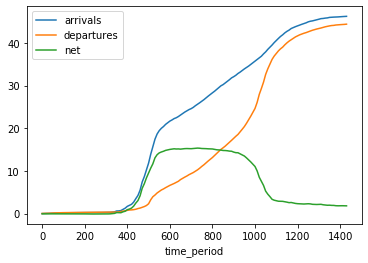

In [46]:
mean_melt2.xs(6, level=0).plot()

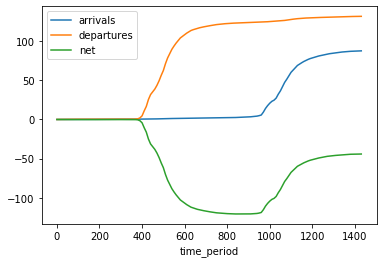

In [47]:
mean_melt2.xs(361, level=0).plot()

TODO It would be easy to calculate percentiles here, to give confidence bounds

## Trying the above but delegating more work to sqlite

In [49]:
df3 = pd.read_sql_query(
    """WITH 
        departures AS (
            SELECT
                "StartStation Id" AS station
                ,CAST(strftime('%j', "Start Date") AS INT) AS day_of_year
                ,CAST(minute_of_day/10 AS INT)*10 AS time_period
                ,COUNT(*) AS departures
            FROM
                journeys
            WHERE
                year = 2019
                AND weekday_ind = 1
                AND "StartStation Id" = 6
            GROUP BY
                1,2,3)
        ,arrivals AS (
            SELECT
                "EndStation Id" AS station
                ,CAST(strftime('%j', "End Date") AS INT) AS day_of_year
                ,CAST((strftime('%H',"End Date")*60 + strftime('%M',"End Date"))/10 AS INT)*10 AS time_period
                ,COUNT(*) AS arrivals
            FROM
                journeys
            WHERE
                -- For indexing-purposes I assume that Start Date and End Date have the same year
                -- and the same weekday_ind. This will be false for a trace number of fringe cases, but does
                -- not justify creating new indexes and columns. 
                year = 2019
                AND weekday_ind = 1
                AND "EndStation Id" = 6
            GROUP BY
                1,2,3)

        ,joiner AS (
            SELECT station, time_period, day_of_year FROM departures
            UNION
            SELECT station, time_period, day_of_year FROM arrivals
        )

    SELECT
        joiner.station
        ,joiner.day_of_year
        ,joiner.time_period
        ,IFNULL(departures,0) AS departures
        ,IFNULL(arrivals, 0) AS arrivals
        ,SUM(departures) OVER (PARTITION BY joiner.station, joiner.day_of_year ORDER BY joiner.time_period ASC ) AS cumi_departures
        ,SUM(arrivals) OVER (PARTITION BY joiner.station, joiner.day_of_year ORDER BY joiner.time_period ASC) AS cumi_arrivals
    FROM 
        -- SQLite does not support outer joins, so this is a workaround. 
        joiner
        LEFT JOIN departures
            ON joiner.station = departures.station
            AND joiner.time_period = departures.time_period
            AND joiner.day_of_year = departures.day_of_year
        LEFT JOIN arrivals
            ON joiner.station = arrivals.station
            AND joiner.time_period = arrivals.time_period
            AND joiner.day_of_year = arrivals.day_of_year
    """
    ,db)

In [51]:
df3.fillna(0, inplace=True)
df3.head()

,station,day_of_year,time_period,departures,arrivals,cumi_departures,cumi_arrivals
0,6,1,50,1,0,1.0,0.0
1,6,1,60,2,0,3.0,0.0
2,6,1,150,0,1,3.0,1.0
3,6,1,170,2,0,5.0,1.0
4,6,1,400,0,1,5.0,2.0


In [52]:
df3['cumi_net'] = df3['cumi_arrivals'] - df3['cumi_departures']

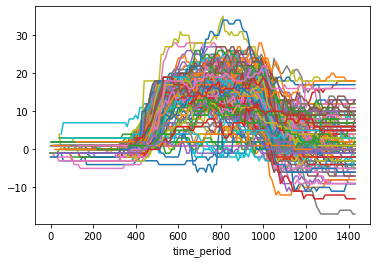

In [60]:
df3[df3.station==6].pivot_table(index='time_period', columns='day_of_year', values='cumi_net').ffill().plot(legend=False);

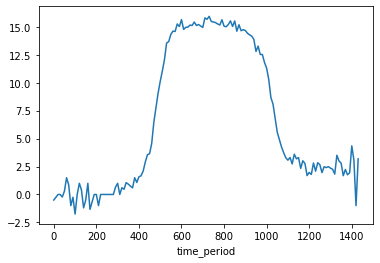

In [62]:
df3[df3.station==6].pivot_table(index='time_period', columns='day_of_year', values='cumi_net').mean(axis=1).plot()

This should work better if you pivot with all tables and fill missing values with zero: that way inactive minutes will still be counted 